### Denver B-Cycle: When are People Using the City's Bike Share system?###

**Name: Sam Cramer**

**Assignment: CSPB 3022 Final Project**

**Dataset Description**
***
Denver B-Cycle is part of a nationwide bike sharing organization that provides an infrastructure bikes in different cities that can be used by anyone with the app. They publish their annual trip data which is a record of every trip made using the bike share system. I'll be using the annual trip data for 2018. In conjunction with this data I will be using data downloaded from the National Weather Service detailing the precipitation and snowfall of each day in 2018 in the Denver area in order to cross reference bike share traffic with the weather.
***

**Project Goal**
***
The goal of this project is to use the two datasets above to create predictive models about when people are most likely to use the bike share system. I will be looking at daily metrics such as number of trips, precipitation and snowfall, and trip duation to create these predictive models. I will be conducting regression and prediction study, since I will be creating models that predict a continuous value for how many people are going to ride the bike share bikes at a given time. 
***
**Assumptions**
***
My assumptions are pretty basic. I expect that there will be less use of the bikes on days with higher precipitation or snowfall. In the same vein, I expect ride duration to be lower on those same days. It will be interesting to map which bike share stations are still getting traffic on bad weather days. 
***
**Cleaning**
***
There is some necessary cleaning to be done for effective analysis. The B-Cycle data is represented as each row is one trip from 2018, so I will need to group it by date and create a sum to get data like number of trips on a given day. The weather data will also be shrunken to only include the relevant columns for the actualy project. Both datasets are represented here as they were originally downloaded. At this time, I don't foresee needing to transform any of my data for analysis.
***

In [78]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import math
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#pd.set_option('display.max_rows', 735)

In [2]:
weather = pd.read_csv('weather.csv')
bcycle = pd.read_csv('BCYCLE.csv')

bcycle.head()

,User's Program,User ID,Membership Type,Bike,Checkout Date,Checkout Time,Checkout Kiosk,Bike Checkout Method,Return Date,Return Time,Return Kiosk,Duration (Minutes)
0,Denver B-cycle,1888760,Monthly (Denver B-cycle),632,1/1/18,5:24 AM,9th & Downing,Kiosk Phone Lookup,1/1/18,5:27 AM,9th & Logan,3
1,Denver B-cycle,1616871,24-hour Kiosk Only (Denver B-cycle),22,1/1/18,5:42 AM,15th & Delgany,New Kiosk Purchase,1/1/18,5:49 AM,17th & Blake,7
2,Denver B-cycle,1780439,Monthly (Denver B-cycle),675,1/1/18,7:55 AM,21st & Lawrence,Rfid,1/1/18,8:01 AM,1550 Glenarm,6
3,Denver B-cycle,28312,Annual Plus (Denver B-cycle),524,1/1/18,7:59 AM,11th & Delaware,Rfid,1/1/18,8:05 AM,10th & Osage,6
4,Denver B-cycle,1240434,Annual Plus (Denver B-cycle),576,1/1/18,8:28 AM,11th & Emerson,Kiosk Phone Lookup,1/1/18,8:41 AM,16th & Wynkoop,13


In [3]:
weather.head()

,STATION,DATE,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,TAVG,...,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT11
0,US1COJF0365,2018-01-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1COJF0365,2018-01-02,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1COJF0365,2018-01-03,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1COJF0365,2018-01-04,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1COJF0365,2018-01-05,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning and EDA ###

In [4]:
#Cleaning the B-Cycle Dataset..
#In the dataset I downloaded, there was no data for 8/7/18, so I inserted a row of 0s as a place holder to line up
#with my weather data. I have no explanation for this and I couldn't find news of a shut down on Denver B-Cycle's Website,
#so I'm chalking it up to a loss of data on their end. 
#I isolate and pull out the variables I want from the raw bcycle data I want, like numbers of trips a day,
#average trip duration each day, and 
bcycle.rename(columns={'Checkout Date' : 'CheckoutDate'}, inplace = True)
bcycle.rename(columns={'Duration (Minutes)' : 'Duration'}, inplace = True)
dt = pd.DataFrame({"Y" : [d.split('/')[2] for d in bcycle.CheckoutDate], "M" : [d.split('/')[0] for d in bcycle.CheckoutDate], "D" : [d.split('/')[1] for d in bcycle.CheckoutDate]})
dt_a = pd.DataFrame({'Y' : 18, "M" : 8, "D" : 7} , index = [0])
dt = dt.astype(float)
dt = dt.append(dt_a)
daily_trips = dt.groupby(['M','D']).count()
daily_trips.rename(columns={'Y' : 'Riders'}, inplace = True)


dd = pd.DataFrame({"Duration" : bcycle.Duration, "M" : [d.split('/')[0] for d in bcycle.CheckoutDate], "D" : [d.split('/')[1] for d in bcycle.CheckoutDate]})
dd_a = pd.DataFrame({'Duration' : 0, "M" : 8, "D" : 7} , index = [0])
dd = dd.astype(float)
dd = dd.append(dd_a)
daily_duration = dd.groupby(['M','D']).Duration.mean()

In [86]:
daily_trips.head()

Riders
M   D          
1.0 1.0     123
    2.0     468
    3.0     604
    4.0     647
    5.0     590

In [87]:
daily_duration.head()

M    D  
1.0  1.0    12.829268
     2.0    13.155983
     3.0    13.149007
     4.0    16.778980
     5.0    18.676271
Name: Duration, dtype: float64

In [88]:
weather_data = pd.DataFrame({"M" : [d.split('-')[1] for d in weather.DATE], "D" : [d.split('-')[2] for d in weather.DATE], 'Precipitation' : weather.PRCP, 'Snow' : weather.SNOW})
weather_data.fillna(0, inplace = True)
weather_data = weather_data.astype(float)
weather_data = weather_data.groupby(['M','D']).sum()
weather_data.head()

Precipitation  Snow
M   D                       
1.0 1.0           0.05   0.4
    2.0           0.00   0.0
    3.0           0.00   0.0
    4.0           0.10   0.0
    5.0           0.00   0.0

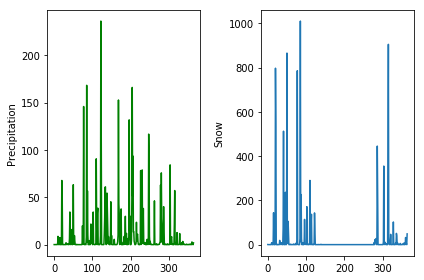

In [6]:
#Here are plots of the precipitation and snow in Denver throughout the year. 
plt.subplot(1,2,1)
plt.plot(np.arange(0,365), weather_data['Precipitation'],color='green')
plt.ylabel("Precipitation")

plt.subplot(1,2,2)
plt.plot(np.arange(0,365), weather_data['Snow'])
plt.ylabel("Snow")

plt.tight_layout()

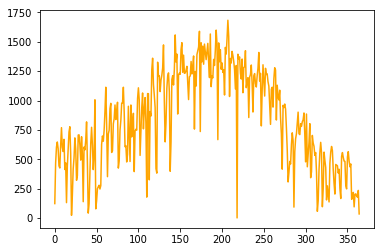

In [7]:
#Here is the plot fo rider uses throughout the year.
plt.plot(np.arange(0,365), daily_trips['Riders'],color='orange')

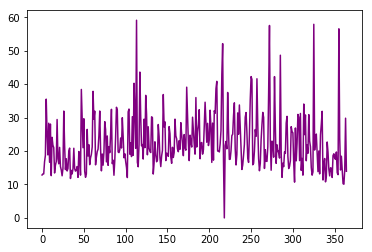

In [8]:
#Here is the plot for daily mean ride duration (minutes) throughout the year.
plt.plot(np.arange(0,365),daily_duration, color='purple')

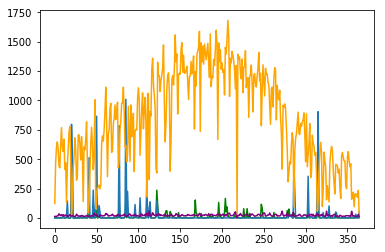

In [9]:
#Here are all three overlayed just to get an idea of how they wax and wane together. 
#NOT to scale.
plt.plot(np.arange(0,365), weather_data['Precipitation'],color='green')
plt.plot(np.arange(0,365), weather_data['Snow'])
plt.plot(np.arange(0,365), daily_trips['Riders'],color='orange')
plt.plot(np.arange(0,365),daily_duration, color='purple')

In [75]:
#Creating a database that contains all of these variables
#All values were changed to floats in the previously cleaning steps in order to 
rough_riders = pd.DataFrame({'Riders' : daily_trips['Riders'], "Duration" : daily_duration, 'Precipitation': weather_data['Precipitation'], 'Snow' : weather_data['Snow']} )
rough_riders.fillna(0,inplace=True)
rough_riders.describe()

,Riders,Duration,Precipitation,Snow
count,365.000000,365.000000,365.000000,365.000000
mean,836.824658,22.417086,10.070575,26.409315
std,403.716807,8.215822,27.650053,117.600544
min,1.000000,0.000000,0.000000,0.000000
25%,521.000000,16.885110,0.000000,0.000000
50%,813.000000,20.526357,0.220000,0.000000
75%,1209.000000,27.099921,3.690000,0.800000
max,1683.000000,59.083077,236.050000,1010.100000


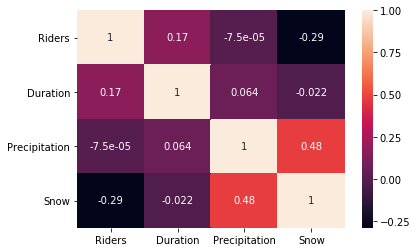

In [11]:
#A correlation table gives a rough overview of 
sns.heatmap(rough_riders.corr(), annot = True)

The correlation matrix confirms some of my previous assumptions about riders. For example, there is an inverse correlation between riders and precipitation and snow. 

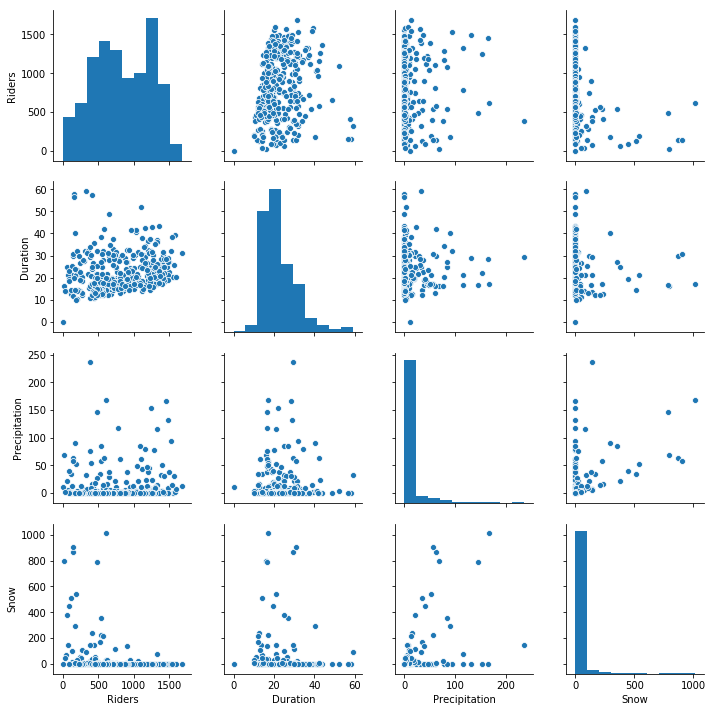

In [12]:
sns.pairplot(rough_riders)

In the plot matrix, we see again that the majority of B-Cycle users seem to be fairweather riders, avoiding snow and precipitation. It is hard to tell as what point the number of riders sees the largest drop off based on increased levels of precipitation and snow, so hopefully my regression model sheds some light on that!

### Modeling ###

In [83]:
#I will show the models predicting riders with a single predictor, but will not produce models based on their data.
rider_rain_model = smf.ols(formula='Riders~Precipitation', data=rough_riders).fit()
r1, r2 = rider_rain_model.params

rider_snow_model = smf.ols(formula='Riders~Snow', data=rough_riders).fit()
s1, s2 = rider_snow_model.params
rider_rain_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Riders   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                 2.020e-06
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.999
Time:                        18:36:02   Log-Likelihood:                -2707.7
No. Observations:                 365   AIC:                             5419.
Df Residuals:                     363   BIC:                             5427.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       836.8356     22.524     37.153      0.000     792.542     881.130
Precipitation    -0.0011      0.766     -0.001      0.999      -1.508       1.506
==============================================================================
Omnibus:                       93.580   Durbin-Watson:                   0.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.450
Skew:                          -0.084   Prob(JB):                     0.000163
Kurtosis:                       1.942   Cond. No.                         31.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
rider_snow_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Riders   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     33.48
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           1.56e-08
Time:                        16:31:11   Log-Likelihood:                -2691.6
No. Observations:                 365   AIC:                             5387.
Df Residuals:                     363   BIC:                             5395.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    863.1691     20.753     41.592      0.000     822.358     903.981
Snow          -0.9975      0.172     -5.786      0.000      -1.337      -0.658
==============================================================================
Omnibus:                       77.816   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.142
Skew:                          -0.067   Prob(JB):                     0.000312
Kurtosis:                       1.979   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#Here is the summary of riders with two predictors. 
riders_rs_model = smf.ols(formula='Riders~Precipitation+Snow', data=rough_riders).fit()

riders_rs_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Riders   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     22.25
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           7.71e-10
Time:                        16:31:11   Log-Likelihood:                -2686.5
No. Observations:                 365   AIC:                             5379.
Df Residuals:                     362   BIC:                             5391.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       844.4940     21.316     39.618      0.000     802.576     886.412
Precipitation     2.6301      0.825      3.189      0.002       1.008       4.252
Snow             -1.2933      0.194     -6.670      0.000      -1.675      -0.912
==============================================================================
Omnibus:                       62.766   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.082
Skew:                          -0.099   Prob(JB):                     0.000531
Kurtosis:                       2.024   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

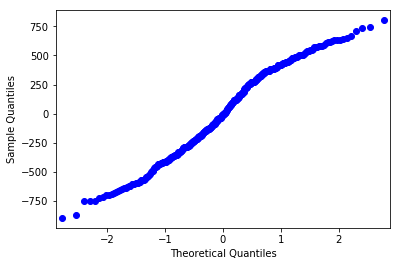

In [16]:
sm.qqplot(riders_rs_model.resid);

In [62]:
duration_rs_model = smf.ols(formula='Duration~Precipitation+Snow', data=rough_riders).fit()

duration_rs_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Duration   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.395
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.249
Time:                        17:14:52   Log-Likelihood:                -1284.7
No. Observations:                 365   AIC:                             2575.
Df Residuals:                     362   BIC:                             2587.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        22.2536      0.458     48.598      0.000      21.353      23.154
Precipitation     0.0287      0.018      1.618      0.107      -0.006       0.064
Snow             -0.0047      0.004     -1.138      0.256      -0.013       0.003
==============================================================================
Omnibus:                      109.219   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.605
Skew:                           1.424   Prob(JB):                     7.87e-64
Kurtosis:                       6.316   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

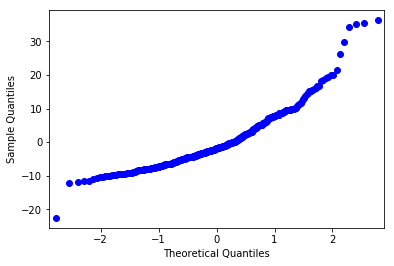

In [63]:
sm.qqplot(duration_rs_model.resid);

In [17]:
beta0, beta_prcp, beta_snow = riders_rs_model.params

prcp_x = np.arange(0,240)
snow_x = np.arange(0,1050)

B1, B2 = np.meshgrid(snow_x, prcp_x, indexing='xy')

Z = np.zeros((prcp_x.size, snow_x.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(beta0 + B1[i,j]*beta_snow + B2[i,j]*beta_prcp)
        
from mpl_toolkits.mplot3d import axes3d

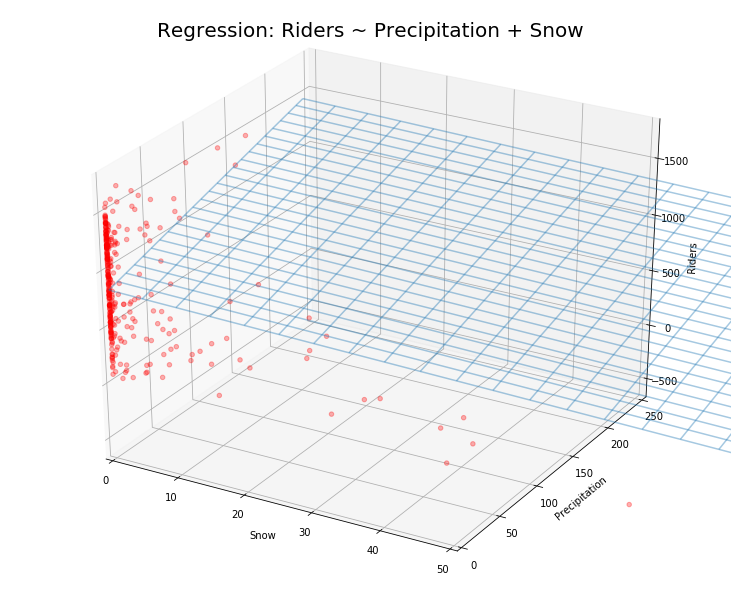

In [58]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Regression: Riders ~ Precipitation + Snow', fontsize=20)

ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(rough_riders.Snow, rough_riders.Precipitation, rough_riders.Riders, c='r')

ax.set_xlabel('Snow')
ax.set_xlim(0,50)
ax.set_ylabel('Precipitation')
ax.set_ylim(ymin = 0)
ax.set_zlabel('Riders');

I referenced our lecture examples heavily to create these 3D models and still found them really clunky to create. The plane serving as the regression line extends so far beyond the boundaries of the graph to outliers in the data, because the outliers were actually recorded I kept them in the data. 

In [64]:
deta0, deta_prcp, deta_snow = duration_rs_model.params

prcp_x = np.arange(0,240)
snow_x = np.arange(0,1050)

D1, D2 = np.meshgrid(snow_x, prcp_x, indexing='xy')

Z2 = np.zeros((prcp_x.size, snow_x.size))

for (i,j),v in np.ndenumerate(Z):
        Z2[i,j] =(deta0 + D1[i,j]*deta_snow + D2[i,j]*deta_prcp)
        
from mpl_toolkits.mplot3d import axes3d

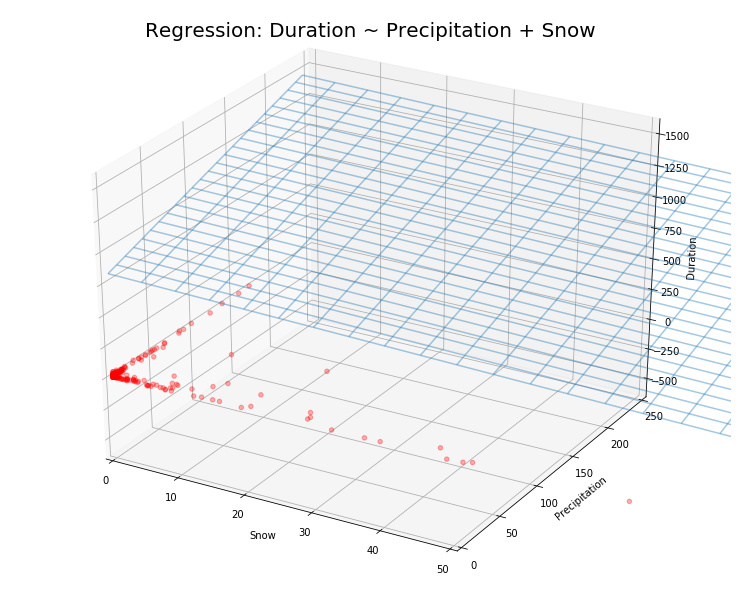

In [65]:
fig2 = plt.figure(figsize=(10,8))
fig2.suptitle('Regression: Duration ~ Precipitation + Snow', fontsize=20)

ax = axes3d.Axes3D(fig2)
ax.plot_wireframe(D1, D2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(rough_riders.Snow, rough_riders.Precipitation, rough_riders.Duration, c='r')

ax.set_xlabel('Snow')
ax.set_xlim(0,50)
ax.set_ylabel('Precipitation')
ax.set_ylim(ymin = 0)
ax.set_zlabel('Duration');

### Time for Predictions ###

In [81]:
#This is the code for my prediction model of the number of Riders.
X = rough_riders.iloc[:,rough_riders.columns != 'Riders']
Y = rough_riders.iloc[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
r2_value = r2_score(Y_test, y_pred) 
print("R-Squared Value is: " ,r2_value)

R-Squared Value is:  0.047592811733379925


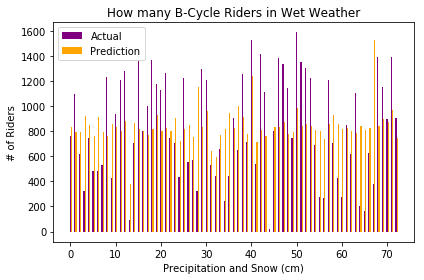

In [70]:
x_vals = np.arange(len(rider_prediction))
actual = Y_test
prediction = y_pred

actualbar = plt.bar(x_vals, actual, .25, color = 'purple', label ='Actual')
predbar = plt.bar(x_vals+.25, prediction, .25, color = 'orange',label='Prediction')

plt.xlabel('Precipitation and Snow (cm)')
plt.ylabel('# of Riders')
plt.title('How many B-Cycle Riders in Wet Weather')
plt.legend()

plt.tight_layout()

In [84]:
#This is the code for my prediction model of the average ride Duration.
X2 = rough_riders.iloc[:,rough_riders.columns != 'Duration']
Y2 = rough_riders.iloc[0:,1]
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state= 0)

model = linear_model.LinearRegression()
model.fit(X2_train, Y2_train)

y2_pred = model.predict(X2_test)
r2_value2 = r2_score(Y2_test, y2_pred) 
print("R-Squared Value is: " ,r2_value2)

R-Squared Value is:  -0.027624385158602216


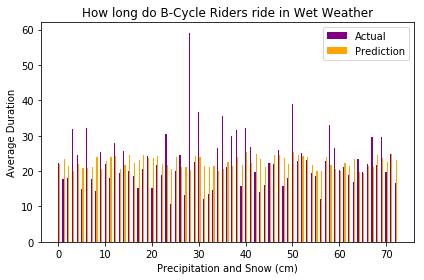

In [85]:
x2_vals = np.arange(len(rider_prediction))
actual2 = Y2_test
prediction2 = y2_pred

actualbar2 = plt.bar(x2_vals, actual2, .25, color = 'purple', label ='Actual')
predbar2 = plt.bar(x2_vals+.25, prediction2, .25, color = 'orange',label='Prediction')

plt.xlabel('Precipitation and Snow (cm)')
plt.ylabel('Average Duration')
plt.title('How long do B-Cycle Riders ride in Wet Weather')
plt.legend()

plt.tight_layout()

### Conclusion and Analysis ###

As can be seen from my models, I did not get the fits I was hoping for. While I initially assumed there would be a negative correlation between increased rain and snow and the number of riders and average duration of a ride, my data does not support this hypothesis with the $R^2$ values for the predictors I chose or the regression models. This is confirmed by the prediction models I created and their equally dismal $R^2$ values. These results lead me to beleive that my weather data did not have enough predictors to create meaninful statistics. If I were doing this project again, I would use weather data that included at least 2-3 more predictors to choose from such as daily temperature, the 'feels-like' temperature, wind speed, humidity levels, and cloud coverage. I would then use forward stepwise to choose the most signifcant predictors. With my current data I was limited to the only two predictors available, so there was little I could do to improve my models based on them. 

It is also possible that the weather is just not a great predictor of how many riders will be using the bikes on a given day. For example, I lived and commuted by bike in Denver every day for two years and all the weather determined for me was what outfit I wore on my ride in. For people that are committed to bike commuting, the weather might not play a significant role in their decision, and if they are visiting the city and planning to get around using the bike share system, they may not have a choice other than to use the bikes so the weather doesn't matter. It is also worth thinking more critically about what kind of riders use B-Cycle. The average trip is just 22 minutes, which even on bad weather days is short enough of a trip to avoid the worst weather. Also, more committed riders may have purchased their own bikes, and without that data, it is hard to determine the true impact of weather on the greater rider population. 

